# APS1052 Final Project

The focus if this project is the seed model from the book Machine Learning and Data Science Blueprints for Finance. The goal this project is to use regression modelto predict the future price of an ETF/Stock. 


In [1]:
# Basic Tools
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot

# Feature Engineering
import talib as ta

# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2, f_regression

# Machine Learning
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import FunctionTransformer
from sklearn import linear_model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from scipy.stats import spearmanr
import xgboost as xgb
from sklearn.decomposition import PCA


# Helpers
import helpers.fAux as fAux
import helpers.detrendPrice as detrendPrice
import helpers.WhiteRealityCheckFor1 as WhiteRealityCheckFor1

# Since there are 5 trading days in a week
return_period = 5
trading_days = 253


# 1.Data Preprocessing

## Clean Data

In [2]:
def clean(df):
    new_df = pd.DataFrame()
    new_df["Date"] = pd.to_datetime(df.iloc[:, 0])
    columns_to_clean = ["Open", "High", "Low", "Close", "Volume"]
    for col in columns_to_clean:
        new_df[col] = df[col].astype(str).str.replace(r'[\$,]', '', regex=True).astype(str).astype(float)
    return new_df


## Load data

In [3]:
# stocks
AAPL = clean(pd.read_csv('data/stock/AAPL.csv'))
AMD = clean(pd.read_csv('data/stock/AMD.csv'))
AMZN = clean(pd.read_csv('data/stock/AMZN.csv'))
GOOGL = clean(pd.read_csv('data/stock/GOOGL.csv'))
INTC = clean(pd.read_csv('data/stock/INTC.csv'))
MSFT = clean(pd.read_csv('data/stock/MSFT.csv'))
NVDA = clean(pd.read_csv('data/stock/NVDA.csv'))


# indices
SPY = clean(pd.read_csv('data/etf/SPY.csv'))
QQQ = clean(pd.read_csv('data/etf/QQQ.csv'))
IEF = clean(pd.read_csv('data/etf/IEF.csv'))

# Use TSLA as testing etf to determine the effective of our model
TSLA = clean(pd.read_csv('data/stock/TSLA.csv'))

stocks = [AAPL, AMD, AMZN, GOOGL, INTC, MSFT, NVDA, TSLA, SPY, QQQ]

In [4]:
AAPL

,Date,Open,High,Low,Close,Volume
0,2025-03-07,235.1050,241.3700,234.7600,239.0700,46273570.0
1,2025-03-06,234.4350,237.8600,233.1581,235.3300,45170420.0
2,2025-03-05,235.4200,236.5500,229.2300,235.7400,47227640.0
3,2025-03-04,237.7050,240.0700,234.6800,235.9300,53798060.0
4,2025-03-03,241.7900,244.0272,236.1120,238.0300,47183990.0
...,...,...,...,...,...,...
2511,2015-03-13,31.1000,31.3488,30.6450,30.8975,206978680.0
2512,2015-03-12,30.5775,31.2250,30.4075,31.1125,192933080.0
2513,2015-03-11,31.1875,31.1925,30.5275,30.5600,275250760.0
2514,2015-03-10,31.6025,31.8050,30.9500,31.1275,274881440.0


In [5]:
print(AAPL.dtypes)

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
dtype: object


In [6]:
def get_indicator(df, indicators):
    if indicators is None:
        indicators = ['MACD', 'MFI', 'SMA', 'MOM', 'ROC', 'RSI', 'ATR', 'BBANDS']

    timeperiod = 5

    # Create a copy to avoid modifying the original DataFrame
    df = df.copy()

    # Moving Average Convergence Divergence (MACD)
    if 'MACD' in indicators:
        macd, macdsignal, macdhist = ta.MACD(df['Close'].values, fastperiod=12, slowperiod=26, signalperiod=9)
        df['MACD_Diff'] = macd
        df['MACD_Signal'] = macdsignal
        df['MACD_Hist'] = macdhist

    # Money Flow Index (MFI)
    if 'MFI' in indicators:
        df['MFI'] = ta.MFI(df['High'].values, df['Low'].values, df['Close'].values, df['Volume'].values, timeperiod=timeperiod)

    # Simple Moving Average (SMA)
    if 'SMA' in indicators:
        df['SMA_20'] = ta.SMA(df['Close'].values, timeperiod=20)
        df['SMA_50'] = ta.SMA(df['Close'].values, timeperiod=50)

    # Momentum Indicator (MOM)
    if 'MOM' in indicators:
        df['MOM'] = ta.MOM(df['Close'].values, timeperiod=timeperiod)

    # Rate of Change (ROC)
    if 'ROC' in indicators:
        df['ROC'] = ta.ROC(df['Close'].values, timeperiod=timeperiod)

    # Relative Strength Index (RSI)
    if 'RSI' in indicators:
        df['RSI'] = ta.RSI(df['Close'].values, timeperiod=timeperiod)

    # Average True Range (ATR)
    if 'ATR' in indicators:
        df['ATR'] = ta.ATR(df['High'].values, df['Low'].values, df['Close'].values, timeperiod=timeperiod)

    # Bollinger Bands (BBANDS)
    if 'BBANDS' in indicators:
        df['Upper_BB'], df['Middle_BB'], df['Lower_BB'] = ta.BBANDS(df['Close'].values, timeperiod=20)

    # Fill NaN values generated by TA-Lib
    df.fillna(method='bfill', inplace=True)  # Backfill missing values

    return df

# Feature Engineering

In [7]:
column_names = ["AAPL", "AMD", "AMZN", "GOOGL", "INTC", "MSFT", "NVDA", "SPY", "QQQ", "TSLA_pred"]

appended_data = []
for stock, name in zip(stocks, column_names):
    temp = pd.DataFrame(np.log(stock["Close"]).diff(return_period).shift(-return_period))
    temp.columns = [name]
    appended_data.append(temp)

dataset = pd.concat(appended_data, axis=1)

multipliers = [2, 4, 6, 10]

tsla_lags = pd.concat(
    [np.log(TSLA["Close"]).diff(return_period * m) for m in multipliers],
    axis=1
)
tsla_lags.columns = [f"TSLA_{return_period * m}" for m in multipliers]

combined_df = pd.concat([dataset, tsla_lags], axis=1)
clean_df = combined_df.dropna()
sampled_df = clean_df.iloc[::return_period, :]
full_data = sampled_df.reset_index(drop=True)

Y = full_data[["TSLA_pred"]]
X = full_data.drop('TSLA_pred', axis=1)
X = X.join(get_indicator(TSLA, None).iloc[:,-5:])
X = X.fillna(X.mean())

p1=pd.DataFrame(np.log(SPY['Close']))
p2=pd.DataFrame(np.log(IEF['Close']))
mfi=(p1.subtract(p2).dropna())
mfi=mfi.rolling(20).mean()
mfi.columns = ['Mfi']
X = X.join(mfi)

tsl = get_indicator(TSLA, ['SMA','ROC','MOM'])
X = X.join(tsl.iloc[:,-5:])
X = X.fillna(X.mean())
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=0)

/var/folders/9g/28x2cnp16b547zblzb11k4qh0000gn/T/ipykernel_45635/186933706.py:47: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)  # Backfill missing values
/var/folders/9g/28x2cnp16b547zblzb11k4qh0000gn/T/ipykernel_45635/186933706.py:47: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)  # Backfill missing values


In [8]:
X

,AAPL,AMD,AMZN,GOOGL,INTC,MSFT,NVDA,SPY,QQQ,TSLA_10,...,ATR,Upper_BB,Middle_BB,Lower_BB,Mfi,Volume,SMA_20,SMA_50,MOM,ROC
0,-0.025309,0.062592,0.011230,-0.008341,0.041150,0.024145,-0.003346,0.035394,0.021852,0.065511,...,20.683980,388.500703,317.8490,247.197297,1.664640,102369600.0,317.8490,371.7132,30.31,11.539194
1,-0.021550,0.088042,-0.001892,-0.082949,0.028116,-0.008307,0.059217,-0.114025,0.005941,0.044101,...,20.683980,388.500703,317.8490,247.197297,1.664640,98451570.0,317.8490,371.7132,30.31,11.539194
2,-0.022951,-0.010262,-0.088073,-0.033525,0.139429,-0.046397,-0.029857,-0.120137,-0.008692,-0.078631,...,20.683980,388.500703,317.8490,247.197297,1.664640,94042910.0,317.8490,371.7132,30.31,11.539194
3,-0.037828,0.002294,-0.046825,-0.007844,0.016086,-0.025326,0.059122,-0.016122,-0.014847,-0.234162,...,20.683980,388.500703,317.8490,247.197297,1.664640,126706600.0,317.8490,371.7132,30.31,11.539194
4,-0.001314,0.009771,0.063946,0.046336,0.023854,0.033394,0.000613,-0.087515,-0.000539,-0.136259,...,20.683980,388.500703,317.8490,247.197297,1.664640,115551400.0,317.8490,371.7132,30.31,11.539194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,-0.002299,0.011173,-0.028178,0.009367,-0.007331,-0.002885,-0.022615,-0.020504,-0.010605,-0.105221,...,9.234370,206.673701,185.0425,163.411299,1.416860,120851600.0,185.0425,181.3552,-2.96,-1.519741
489,0.002853,0.000000,0.000481,0.029434,0.006378,-0.013820,-0.018095,-0.064415,0.004669,-0.029860,...,8.429496,205.533316,186.4355,167.337684,1.414349,116531600.0,186.4355,180.7372,-17.05,-8.218452
490,0.006625,0.050552,0.001387,0.007517,-0.008299,0.045226,0.056330,0.046446,0.008368,-0.084919,...,8.875597,204.310411,187.7925,171.274589,1.411336,144193900.0,187.7925,180.2294,-3.06,-1.566981
491,-0.017926,-0.028573,-0.004703,-0.006619,-0.011930,-0.030684,0.011383,-0.019883,-0.006785,-0.017969,...,9.042478,201.206053,189.2005,177.194947,1.408634,150376400.0,189.2005,179.7730,-2.73,-1.408087


In [9]:
Y

,TSLA_pred
0,0.022628
1,-0.007663
2,-0.032313
3,-0.009382
4,0.007320
...,...
488,-0.012866
489,0.008752
490,0.014788
491,-0.015069


In [10]:
pipe = Pipeline([("scaler", StandardScaler()), ("PCA", PCA()), ('xgb', xgb.XGBRegressor(verbosity=0))])

# Parameters for GridSearch
n_estimators  = [10, 50]
max_depth = [1, 3, 6, 20, 50]
learning_rate = [0.001, 0.01, 0.1, 0.25, 0.5, 1]
objective = ['reg:squarederror']
booster = ['gbtree', 'gblinear', 'dart']
gamma = [0, 1, 20]
base_score = [0.2, 0.5 ,0.7]
subsample = [0.2, 0.5, 1]
sampling_method = ['uniform', 'gradient_based']
tree_method = ['auto', 'exact', 'approx', 'hist']
min_child_weight = [0, 1, 5, 10]
max_delta_step = [0, 1, 20, 50]
n_components = [1, 2]

# parameter grid 
para_grid = {'xgb__n_estimators': n_estimators,
            'xgb__max_depth': max_depth,
            'xgb__learning_rate': learning_rate,
            'xgb__objective': objective,
            'xgb__booster': booster,
            'xgb__gamma': gamma,
            'xgb__base_score': base_score,
            'xgb__subsample': subsample,
            'xgb__sampling_method': sampling_method,
            'xgb__tree_method': tree_method,
            'xgb__min_child_weight': min_child_weight,
            'xgb__max_delta_step': max_delta_step,
            'PCA__n_components': n_components
            }

print('Parameter grid: {}' .format(para_grid))

Parameter grid: {'xgb__n_estimators': [10, 50], 'xgb__max_depth': [1, 3, 6, 20, 50], 'xgb__learning_rate': [0.001, 0.01, 0.1, 0.25, 0.5, 1], 'xgb__objective': ['reg:squarederror'], 'xgb__booster': ['gbtree', 'gblinear', 'dart'], 'xgb__gamma': [0, 1, 20], 'xgb__base_score': [0.2, 0.5, 0.7], 'xgb__subsample': [0.2, 0.5, 1], 'xgb__sampling_method': ['uniform', 'gradient_based'], 'xgb__tree_method': ['auto', 'exact', 'approx', 'hist'], 'xgb__min_child_weight': [0, 1, 5, 10], 'xgb__max_delta_step': [0, 1, 20, 50], 'PCA__n_components': [1, 2]}


In [11]:
from sklearn.metrics import r2_score
np.random.seed(2)
#Fit the randomized search object with Xtrain and ytrain.ravel()
rso = RandomizedSearchCV(pipe,
                         para_grid,
                         n_iter= 100,
                         random_state = 42,
                         scoring = make_scorer(r2_score, greater_is_better=True),
                         )

# Fit the model to find the best hyperparameter values
rso.fit(x_train, y_train)

print('Best parameters:', rso.best_params_)
print("rso best score: ", rso.best_score_) 

Best parameters: {'xgb__tree_method': 'auto', 'xgb__subsample': 0.2, 'xgb__sampling_method': 'gradient_based', 'xgb__objective': 'reg:squarederror', 'xgb__n_estimators': 50, 'xgb__min_child_weight': 10, 'xgb__max_depth': 20, 'xgb__max_delta_step': 20, 'xgb__learning_rate': 0.25, 'xgb__gamma': 0, 'xgb__booster': 'gblinear', 'xgb__base_score': 0.5, 'PCA__n_components': 2}
rso best score:  0.9416816115379334


/opt/anaconda3/envs/aps1052/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
190 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/aps1052/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/aps1052/lib/python3.10/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/envs/aps1052/lib/python3.10/site-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estima

In [12]:
best_xgb = xgb.XGBRegressor(tree_method='hist', subsample=0.5, sampling_method='uniform',
                            objective='reg:squarederror', n_estimators=100,
                            min_child_weight=0, max_depth=3, max_delta_step=0,
                            learning_rate=0.1, gamma=1, booster='gblinear',
                            base_score=0.2)

In [13]:
scaler = StandardScaler()
scaler.fit(x_train)
X_train = scaler.transform(x_train)
X_test = scaler.transform(x_test)

# PCA the features
pca = PCA(n_components=2)
pca.fit(x_train)
X_train = pca.transform(x_train)
X_test = pca.transform(x_test)

best_xgb.fit(x_train, y_train)

/opt/anaconda3/envs/aps1052/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:01:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "gamma", "max_delta_step", "max_depth", "min_child_weight", "sampling_method", "subsample", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=0.2, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
             max_depth=3, max_leaves=None, min_child_weight=0, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

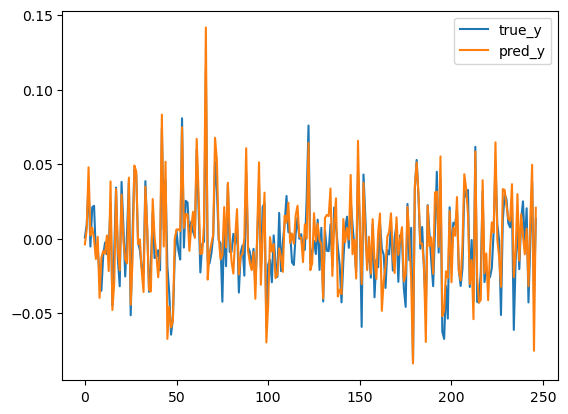

In [14]:
true_y = y_test.values.ravel()
pred_y = best_xgb.predict(x_test)

from matplotlib import pyplot
pyplot.plot(true_y, label='true_y')
pyplot.plot(pred_y, label='pred_y')
pyplot.legend()
pyplot.show()

# Validation

In [15]:
from scipy.special import ndtr
from sklearn.metrics import accuracy_score
from phik.report import plot_correlation_matrix

df_ret = TSLA.iloc[Y.index.values]['Close'].pct_change(periods=1).fillna(0)

In [16]:
df_ret1 = df_ret.reset_index(drop= True)[:x_train.shape[0],]
df_ret2 = df_ret.reset_index(drop= True)[x_train.shape[0]:,]

In [17]:
positions = np.where(best_xgb.predict(x_train)> 0,1,-1 ) 
dailyRet = pd.Series(positions).shift(1).fillna(0).values * df_ret1
dailyRet = dailyRet.fillna(0)
cumret = np.array(np.cumprod(dailyRet + 1) - 1)

# plt.figure(2)
# plt.plot(cumret2.index, cumret2)
# plt.title('Cross-validated LogisticRegression on currency: test set')
# plt.ylabel('Cumulative Returns')
# plt.xlabel('Date')
# #plt.show()
# plt.savefig(r'Results\%s.png' %("TestCumulative2"))

# #metrics
# accuracy_score = accuracy_score(y_test.values.ravel(), grid_search.predict(x_test.values))

# #If this figure does not plot correctly select the lines and press F9 again
# arr1 = y_test.values.ravel()
# arr2 = grid_search.predict(x_test.values)
# dfc = pd.DataFrame({'y_true': arr1, 'y_pred': arr2})
# phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
# significance_overview = dfc.significance_matrix(interval_cols=[])
# phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
# phi_k_p_val = 1 - ndtr(phi_k_sig) 
# plot_correlation_matrix(significance_overview.fillna(0).values, 
#                         x_labels=significance_overview.columns, 
#                         y_labels=significance_overview.index, 
#                         vmin=-5, vmax=5, title="Significance of the coefficients", 
#                         usetex=False, fontsize_factor=1.5, figsize=(7, 5))
# plt.tight_layout()
# #plt.show()
# plt.savefig(r'Results\%s.png' %("Significance2"))

rho, pval = spearmanr(y_test,best_xgb.predict(x_test)) #spearman's rank correlation: very small but significant

cagr = (1 + cumret[-1]) ** ((trading_days/return_period) / len(cumret)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret)
ratio = ((trading_days/return_period) ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
print (('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6} Rho={:0.6} PVal={:0.6}\n'\
    ).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, rho, pval))


In-sample: CAGR=-0.0695354 Sharpe ratio=-0.109423 maxDD=-0.709376 maxDDD=235 Calmar ratio=-0.0980234 Rho=0.851982 PVal=8.4136e-71



In [18]:
positions2 = np.where(best_xgb.predict(x_test)> 0,1,-1 )

dailyRet2 = pd.Series(positions2).shift(1).fillna(0).values * df_ret2
dailyRet2 = dailyRet2.fillna(0)

cumret2 = np.array(np.cumprod(dailyRet2 + 1) - 1)

# plt.figure(2)
# plt.plot(cumret2.index, cumret2)
# plt.title('Cross-validated LogisticRegression on currency: test set')
# plt.ylabel('Cumulative Returns')
# plt.xlabel('Date')
# #plt.show()
# plt.savefig(r'Results\%s.png' %("TestCumulative2"))

# #metrics
# accuracy_score = accuracy_score(y_test.values.ravel(), grid_search.predict(x_test.values))

# #If this figure does not plot correctly select the lines and press F9 again
# arr1 = y_test.values.ravel()
# arr2 = grid_search.predict(x_test.values)
# dfc = pd.DataFrame({'y_true': arr1, 'y_pred': arr2})
# phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
# significance_overview = dfc.significance_matrix(interval_cols=[])
# phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
# phi_k_p_val = 1 - ndtr(phi_k_sig) 
# plot_correlation_matrix(significance_overview.fillna(0).values, 
#                         x_labels=significance_overview.columns, 
#                         y_labels=significance_overview.index, 
#                         vmin=-5, vmax=5, title="Significance of the coefficients", 
#                         usetex=False, fontsize_factor=1.5, figsize=(7, 5))
# plt.tight_layout()
# #plt.show()
# plt.savefig(r'Results\%s.png' %("Significance2"))

rho, pval = spearmanr(y_test,best_xgb.predict(x_test)) #spearman's rank correlation: very small but significant

cagr = (1 + cumret2[-1]) ** ((trading_days/return_period) / len(cumret2)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret2)
ratio = ((trading_days/return_period) ** (1.0/2.0)) * np.mean(dailyRet2) / np.std(dailyRet2)
print (('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}  Rho={:0.6} PVal={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, rho, pval))


Out-of-sample: CAGR=-0.0649194 Sharpe ratio=-0.201079 maxDD=-0.44469 maxDDD=147 Calmar ratio=-0.145988  Rho=0.851982 PVal=8.4136e-71



In [19]:
positionsytrain = np.where(y_train.values.ravel() > 0,1,-1 )
dailyRetytrain = pd.Series(positionsytrain).shift(1).fillna(0).values * df_ret1
dailyRetytrain = dailyRetytrain.fillna(0)
cumretytrain = np.array(np.cumprod(dailyRetytrain + 1) - 1)

positionsytest = np.where(y_test.values.ravel() > 0,1,-1 )
dailyRetytest = pd.Series(positionsytest).shift(1).fillna(0).values * df_ret2
dailyRetytest = dailyRetytest.fillna(0)
cumretytest = np.array(np.cumprod(dailyRetytest + 1) - 1)

dates = TSLA.iloc[Y.index.values]['Date']
dates= dates.reset_index(drop= True)[:x_train.shape[0],]



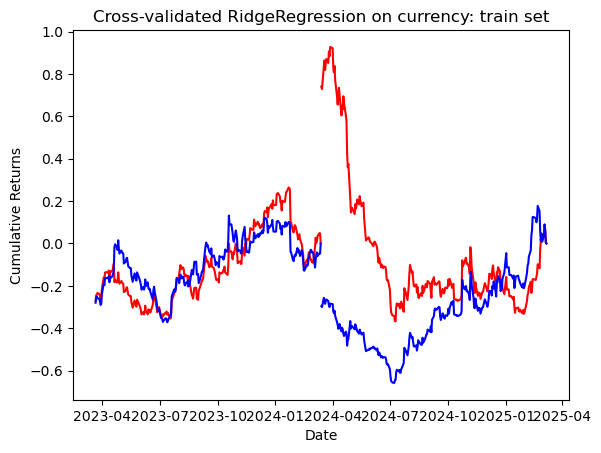

In [20]:

pyplot.figure(1)
pyplot.plot(dates, cumretytrain ,'r')
pyplot.plot(dates, cumret,'b')
pyplot.title('Cross-validated RidgeRegression on currency: train set')
pyplot.ylabel('Cumulative Returns')
pyplot.xlabel('Date')

dates = TSLA.iloc[Y.index.values]['Date']
dates= dates.reset_index(drop= True)[x_train.shape[0]:,]
pyplot.plot(dates, cumretytest ,'red')
pyplot.plot(dates, cumret2,'b')


## white reality check

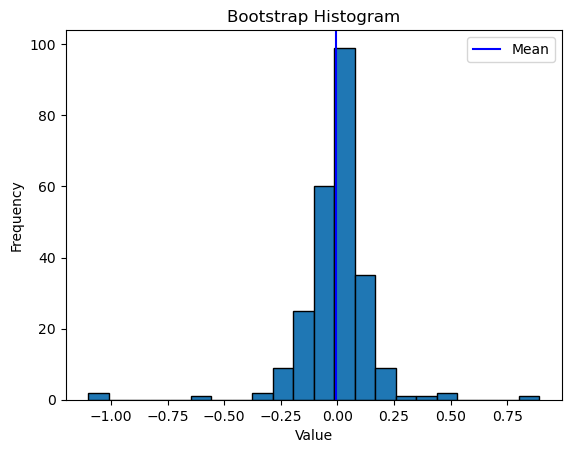

Bootstrap 95% CI for the mean: [-0.0257, 0.0144]


In [21]:
new_close = TSLA.iloc[Y.index.values]['Close'].reset_index(drop=True)[(x_train.shape[0]):,]
detrended_close = detrendPrice.detrendPrice(new_close)
detrended_ret1 = detrended_close.pct_change(periods=1).fillna(0)
detrended_syst_rets = detrended_ret1 * pd.Series(positions2).shift(1).fillna(0)
WhiteRealityCheckFor1.bootstrap(detrended_syst_rets)


In [ ]:
# Train error
train_result = mean_squared_error(best_xgb.predict(x_train), y_train)
test_result = mean_squared_error(best_xgb.predict(x_test), y_test)

print("MSE of train_result:",train_result, "MSE of test_result",test_result)


train_result: 0.00017820416542235762 test_result 0.00019867171067744493
